<a href="https://colab.research.google.com/github/JamesKevinStar/AnalisisSentimientos/blob/main/M%C3%A1quina%20de%20Vector%20de%20Soporte/Proyecto_NLP_Modelo_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio: Clasificación de Tweets de Covid 19 (Análisis de Sentimientos)

#### <a name="Escritura">Alumnos: </a>
*   Estrella Vilca, James Kevin  -  182909
*   Peña Luque, Raísa Melina     -  182927

#### <a name="Escritura">Asignatura: </a>
*   Procesamiento de Lenguaje Natural

#### <a name="Escritura">Docente: </a>
*   Zuñiga Rojas, Gabriela

#### <a name="Escritura">Universidad: </a>
*   Universidad Nacional de San Antonio Abad del Cusco

## Instalar Librerías Necesarias

In [ ]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 22.3 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Importar Librerías

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import joblib
import pickle
import spacy
import math
import nltk
import os
import re

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.python.client import device_lib
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras import metrics
from google.colab import drive
from tqdm import tqdm
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

## Cargar Datos

#### <a name="Escritura">Obtener los datos del Drive</a>

In [ ]:
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Archivos_Covid_NLP'
print(os.listdir())

Mounted at /content/drive
/content/drive/My Drive/Archivos_Covid_NLP
['Corona_NLP_train.csv', 'Corona_NLP_test.csv', 'modelo_entrenado_svm_rbf.pkl', 'Coronavirus_Total.csv', 'modelo_entrenado_svm_poly.pkl', 'modelo_entrenado_Multinomial NB.pkl', 'modelo_entrenado_Regresion Logistica.pkl', 'modelo_entrenado_Bernoulli NB.pkl', 'modelo_entrenado_SVM lineal.pkl', 'modelo_entrenado_SVM polinomico.pkl', 'modelo_entrenado_SVM Kernel rbf.pkl', 'modelo_entrenado_SVM Kernel Sigmoid.pkl', 'modelo_entrenado_SVM.pkl', 'modelo_entrenado_Random Forest d_20.pkl', 'modelo_entrenado_Random Forest d_50.pkl', 'Text.txt', 'Text_primer modelo.txt', 'Text_train.txt', 'Text_train_1.txt', 'Text_train_K.txt', 'Coronavirus_Total.xlsx', 'Text_train_K_1.txt']


#### <a name="Escritura">Mostrar los datos</a>

In [ ]:
data = pd.read_excel('Coronavirus_Total.xlsx')
data.head()

,Source.Name,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,Corona_NLP_test.csv,1.0,44953.0,NYC,2020-02-03,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,Corona_NLP_test.csv,2.0,44954.0,"Seattle, WA",2020-02-03,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Corona_NLP_test.csv,3.0,44955.0,NaN,2020-02-03,Find out how you can protect yourself and love...,Extremely Positive
3,Corona_NLP_test.csv,4.0,44956.0,Chicagoland,2020-02-03,#Panic buying hits #NewYork City as anxious sh...,Negative
4,Corona_NLP_test.csv,5.0,44957.0,"Melbourne, Victoria",2020-03-03,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


#### <a name="Escritura">Eliminar las columnas innecesarias</a>

In [ ]:
data.pop('Source.Name')
data.pop('UserName')
data.pop('ScreenName')
data.pop('Location')
data.pop('TweetAt')
data.head()

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Find out how you can protect yourself and love...,Extremely Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


#### <a name="Escritura">Dividir los datos para test y train</a>

In [ ]:
x = data.drop(["Sentiment"],axis=1).values
y = data["Sentiment"].values

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.07, random_state=20000901)

## Normalización

#### <a name="Escritura">Reemplazar los saltos de líneas y demás</a>

In [ ]:
for tweet in X_train:
  tweet[0]=tweet[0].replace('\n',' ')
  tweet[0]=tweet[0].replace('\r',' ')
  tweet[0]=tweet[0].replace('\t',' ')

for tweet in X_test:
  tweet[0]=tweet[0].replace('\n',' ')
  tweet[0]=tweet[0].replace('\r',' ')
  tweet[0]=tweet[0].replace('\t',' ')

#### <a name="Escritura">Normalizar los datos de test y train</a>

In [ ]:
nlp = spacy.load('en_core_web_sm')

X_train_PN = [doc[0] for doc in X_train]
y_train = [doc for doc in Y_train]

X_test_PN = [doc[0] for doc in X_test]
y_test = [doc for doc in Y_test]

def normalize(sentenses):
    """normalizamos la lista de frases y devolvemos la misma lista de frases normalizada"""
    for index, sentense in enumerate(tqdm(sentenses)):
        sentense = nlp(sentense.lower())
        New_Words = []
        for word in sentense:
            if (not word.is_punct) and (not word.is_stop or (word.text == 'no' or word.text == 'not')) and (not word.text.startswith('@')) and (not word.text.startswith('http')) and (not word.text.startswith('#')) and (not word.text.endswith('.com')) and (not word.text.endswith('.co')) and (not word.text.endswith('.uk')) and (any(map(str.isdigit, word.text)) == False):
                pattern = re.sub(pattern='[^a-z]',repl=' ',string=word.lemma_)
                for p in pattern.split():
                    if len(p) > 2 or p == 'no':
                        New_Words.append(pattern)
        sentenses[index] = ' '.join(New_Words)
    return sentenses

# Normalizamos las frases
X_train_Norm = normalize(X_train_PN)
X_test_Norm = normalize(X_test_PN)

100%|██████████| 3147/3147 [00:26<00:00, 119.78it/s]


## Bolsa de Palabras

#### <a name="Escritura">Obtener la matriz para el entrenamiento</a>

In [ ]:
num_words = 350

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train_Norm)
X_matrix_train = tokenizer.texts_to_matrix(X_train_Norm, mode='count')
X_matrix_test = tokenizer.texts_to_matrix(X_test_Norm, mode='count')

print('Dimensión de la matriz de entrenamiento: {dim}\n'.format(dim=X_matrix_train.shape))
print('Bolsa de palabras de los datos de entrenamiento:\n{bolsa}\n'.format(bolsa=tokenizer.word_counts))
print('Índice de las palabras en la Matriz:\n{index}\n'.format(index=tokenizer.word_index))
print('Matriz de entrenamiento:\n{matrix}\n'.format(matrix=X_matrix_train))
print('Matriz de test:\n{matrix}\n'.format(matrix=X_matrix_test))

print(len(tokenizer.word_counts))

Dimensión de la matriz de entrenamiento: (41808, 350)

Bolsa de palabras de los datos de entrenamiento:
OrderedDict([('oio', 2), ('casino', 13), ('egcc', 1), ('btc', 24), ('soon', 309), ('news', 818), ('pandemic', 3136), ('spread', 1280), ('world', 1022), ('stock', 3242), ('forex', 23), ('cryptocurrencie', 3), ('see', 1158), ('huge', 237), ('fall', 669), ('price', 8862), ('bitc', 1), ('read', 787), ('podcast', 68), ('coronavirus', 17931), ('outbreak', 1155), ('protest', 23), ('retail', 1632), ('store', 8892), ('closure', 260), ('online', 3721), ('shopping', 3044), ('benefit', 234), ('short', 223), ('term', 263), ('supply', 2135), ('chain', 859), ('issue', 462), ('uncertain', 82), ('consumer', 5138), ('demand', 2414), ('dampen', 7), ('commerce', 143), ('outlook', 67), ('affect', 477), ('ecommerce', 230), ('hilarious', 16), ('scary', 83), ('tragic', 13), ('could', 13), ('buy', 2610), ('little', 354), ('please', 33), ('panic', 3021), ('disrupt', 65), ('food', 8096), ('distribution', 155),

## Creacción del Modelo

In [ ]:
svm_rbf = SVC(kernel='rbf',C=10,gamma=0.01)
#svm = SVC()

#clasificadores = {
 #               'SVM Kernel rbf': svm_rbf
  #                }

print ('CREANDO MODELO: SVM Kernel rbf')
svm_rbf.fit(X_matrix_train, y_train)

# Ajustamos los modelos y calculamos el accuracy para los datos de entrenamiento
#for k, v in clasificadores.items():
 #   print ('CREANDO MODELO: {clas}'.format(clas=k))
 #   v.fit(X_matrix_train, y_train)

CREANDO MODELO: SVM Kernel rbf


SVC(C=10, gamma=0.01)

## Evaluación del Modelo

In [ ]:
def evaluation(model, name, X_train, y_train, X_test, y_test):
    """
    Función de devuelve en un diccionario las métricas de evaluación de 
    Accuracy, Precision, Recall y F1 para los conjuntos de datos de entrenamiento y test
        model: modelo a evaluar
        name: nombre del modelo
        X_train: Variables de entrada del conjunto de datos de entrenamiento
        y_train: Variable de salida del conjunto de datos de entrenamiento
        X_test: Variables de entrada del conjunto de datos de test
        y_test: Variable de salida del conjunto de datos de test
        return: diccionario con el nombre del modelo y el valor de las métricas
    """
    model_dict = {}
    model_dict['name'] = name
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    model_dict['accuracy_train'] = accuracy_score(y_true=y_train, y_pred=y_pred_train)
    model_dict['accuracy_tests'] = accuracy_score(y_true=y_test, y_pred=y_pred_test)
    model_dict['precision_train'] = precision_score(y_true=y_train, y_pred=y_pred_train, average='weighted')
    model_dict['precision_tests'] = precision_score(y_true=y_test, y_pred=y_pred_test, average='weighted')
    model_dict['recall_train'] = recall_score(y_true=y_train, y_pred=y_pred_train, average='weighted')
    model_dict['recall_tests'] = recall_score(y_true=y_test, y_pred=y_pred_test, average='weighted')
    model_dict['f1_train'] = f1_score(y_true=y_train, y_pred=y_pred_train, average='weighted')
    model_dict['f1_tests'] = f1_score(y_true=y_test, y_pred=y_pred_test, average='weighted')
    
    return model_dict



# Calculamos las métricas de los modelos por separado
evaluacion = list()

evaluacion.append(evaluation(model=svm_rbf, name='SVM Kernel rbf', 
                                 X_train=X_matrix_train, y_train=y_train,
                                 X_test=X_matrix_test, y_test=y_test))



# Pasamos los resultados a un DataFrame para visualizarlos mejor
df = pd.DataFrame.from_dict(evaluacion)
df.set_index("name", inplace=True)
df

,accuracy_train,accuracy_tests,precision_train,precision_tests,recall_train,recall_tests,f1_train,f1_tests
name,,,,,,,,
SVM Kernel rbf,0.573216,0.506196,0.600771,0.5146,0.573216,0.506196,0.572252,0.4999


* Representamos las métricas para los diferentes modelos en un gráfico de barras:

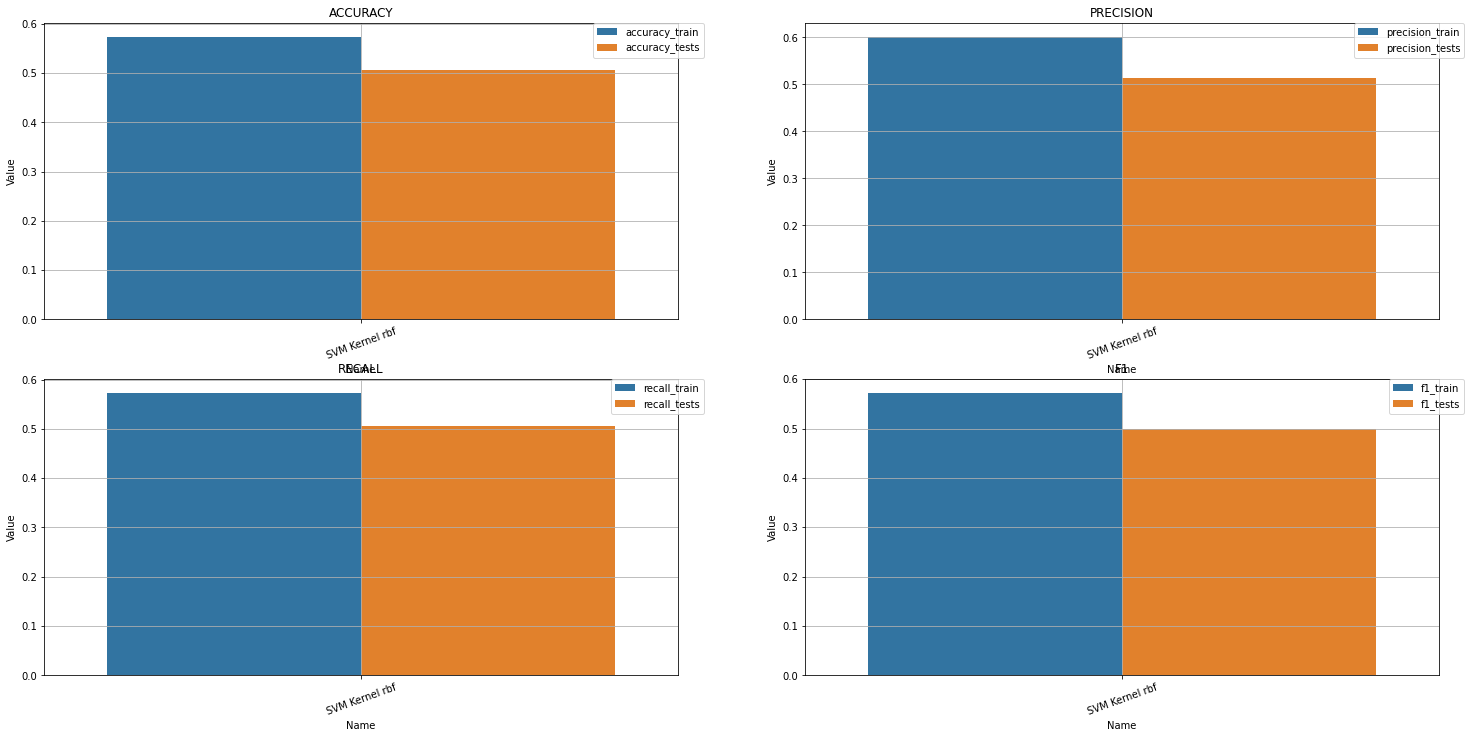

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Métricas a pintar
METRICS = ["accuracy", "precision", "recall", "f1"]

# Transformamos el dataframe para pintar las gráficas con seaborn
df_plot = df.reset_index().melt(id_vars='name').rename(columns=str.title)

plt.figure(figsize=(25, 12))
pos = 1
for metric in METRICS:
    # Filtramos la métrica a pintar
    df_aux = df_plot[df_plot['Variable'].str.contains(metric)]
    
    # Pintamos la gráfica en su posición 2x2
    plt.subplot(2, 2, pos)
    sns.barplot(x='Name', y='Value', hue='Variable', data=df_aux)
    plt.title(metric.upper())
    plt.grid()
    plt.legend(bbox_to_anchor=(1.04, 1), loc=1, borderaxespad=0.)
    plt.xticks(rotation=20)
    pos += 1
plt.show()

In [ ]:
clasificadores = {
                'SVM Kernel rbf': svm_rbf
                 }

* Veamos las matrices de confusión del modelo

Obteniendo Matriz de Confusión de: SVM Kernel rbf


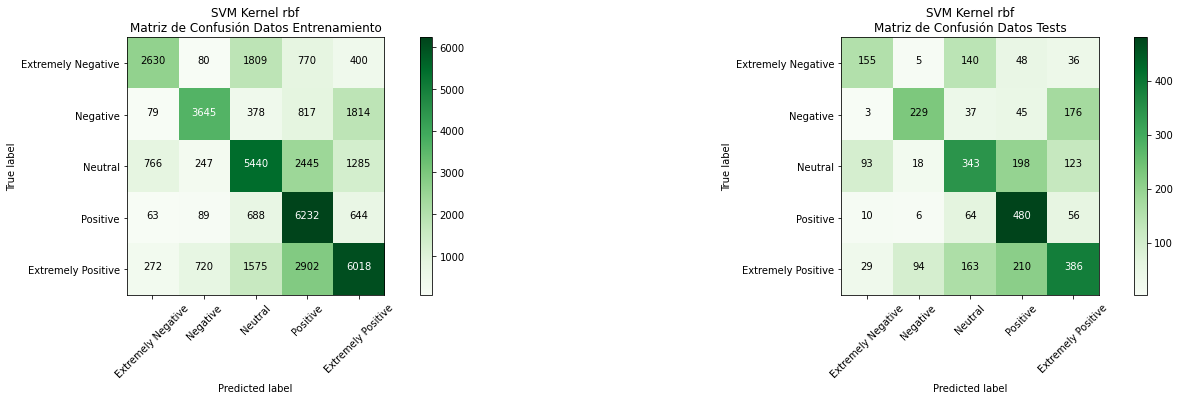

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

from sklearn.metrics import confusion_matrix

# Obtenemos las Matrices de confusión
msc = list()
for k, v in clasificadores.items():
    print ('Obteniendo Matriz de Confusión de: {model}'.format(model=k))
    model = {}
    model['name'] = k
    y_pred_train = v.predict(X_matrix_train)
    y_pred_test = v.predict(X_matrix_test)
    model['confusion_matrix_train'] = confusion_matrix(y_true=y_train, y_pred=y_pred_train)
    model['confusion_matrix_test'] = confusion_matrix(y_true=y_test, y_pred=y_pred_test)
    msc.append(model)

    
# Definimos el heatmap de la matriz de confusión
def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Pintamos las matrices de confusión
plt.figure(figsize=(20, 45))
pos = 0
for mc in msc:
    pos += 1
    plt.subplot(9, 2, pos)
    plot_confusion_matrix(mc['confusion_matrix_train'], classes=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'], 
                          title='{}\nMatriz de Confusión Datos Entrenamiento'.format(mc['name']))
    pos += 1
    plt.subplot(9, 2, pos)
    plot_confusion_matrix(mc['confusion_matrix_test'], classes=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'], 
                          title='{}\nMatriz de Confusión Datos Tests'.format(mc['name'] ))
plt.show()